# Assignment

In [2]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *


size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






## Define parameters and nueral network

In [3]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

In [4]:
S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS (OUPUT SIZE)
N_in=np.shape(X)[0]    ## INPUT SIZE

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 


In [5]:
# Define our neural network, which can be a three-layers or a four-layers network, by changing the variable [N_h2].
# Including initialize network, forward to compute q values and propagate to update neural network

class Neural_network: 
    def __init__(self):
        self.Xavier_init=True
        self.N_h=200               ## NUMBER OF HIDDEN NODES
        self.N_h2=100              ## NUMBER OF HIDDEN 2 NODES(set this to 0 if only need one hidden layer)
        self.N_a=32                ## OUTPUT SIZE 
        self.N_in=58               ## INPUT SIZE (change this if change state representation)
        self.eta=0.0035            ## THE LEARNING RATE

    def parameter_init(self):      #INITIALIZE W PARAMETER
        if self.Xavier_init:       #USE XAVIER INITIALIZATION METHOD
            self.W1 = np.random.randn(self.N_h, self.N_in) * np.sqrt(1 / (self.N_in))
            if self.N_h2>0:
                self.W2 = np.random.randn(self.N_h2, self.N_h) * np.sqrt(1 / (self.N_h))
                self.W3 = np.random.randn(self.N_a, self.N_h2) * np.sqrt(1 / (self.N_h2))
            else:
                self.W2 = np.random.randn(self.N_a, self.N_h) * np.sqrt(1 / (self.N_h))
        else:
            self.W1 = np.random.uniform(0,1,(self.N_h, self.N_in))
            self.W2 = np.random.uniform(0,1,(self.N_a, self.N_h))

            # The following normalises the random weights so that the sum of each row =1
            self.W1 = np.divide(self.W1,np.matlib.repmat(np.sum(self.W1,1)[:,None],1,self.N_in))
            self.W2 = np.divide(self.W2,np.matlib.repmat(np.sum(self.W2,1)[:,None],1,self.N_h))

            if self.N_h2>0:
                self.W3=np.random.uniform(0,1,(self.N_a,self.N_h2))
                self.W3=np.divide(self.W3,np.matlib.repmat(np.sum(self.W3,1)[:,None],1,self.N_h2))

                self.W2=np.random.uniform(0,1,(self.N_h2,self.N_h))
                self.W2=np.divide(self.W2,np.matlib.repmat(np.sum(self.W2,1)[:,None],1,self.N_h))
                
    def biases_init(self):    # INITIALIZE BIAS PARAMETER
        self.bias_W1 = np.zeros((self.N_h,))
        self.bias_W2 = np.zeros((self.N_a,))

        if self.N_h2>0:    
            self.bias_W3=np.zeros((self.N_a,))
            self.bias_W2=np.zeros((self.N_h2,))

    def predict(self,X):     # COMPUTE Q VALUES

            # Neural activation: input layer -> hidden layer
            self.h1 = np.dot(self.W1,X)+self.bias_W1

            # Apply the leaky relu function
            self.x1=np.where(self.h1>0,self.h1,0.01*self.h1)

            # Neural activation: hidden layer -> output layer
            self.h2 = np.dot(self.W2,self.x1)+self.bias_W2

            # Apply the leaky relu function
            self.x2=np.where(self.h2>0,self.h2,0.01*self.h2)

            if self.N_h2 > 0:
                # Neural activation: hidden layer 1 -> hidden layer 2
                self.h3 = np.dot(self.W3,self.x2)+self.bias_W3
                self.q_values = np.where(self.h3>0,self.h3,0.01*self.h3)

            else:
                self.q_values=self.x2

            return self.q_values
            
    def update(self,delta,a,X):    # BACKWARD PROPAGATION
        # Initialise the gradients for each batch
        self.dW1 = np.zeros(self.W1.shape)
        self.dW2 = np.zeros(self.W2.shape)

        self.dbias_W1 = np.zeros(self.bias_W1.shape)
        self.dbias_W2 = np.zeros(self.bias_W2.shape)

        if self.N_h2 > 0:
            self.dW3 = np.zeros(self.W3.shape)
            self.dbias_W3 = np.zeros(self.bias_W3.shape)
            
        # Backpropagation
        if self.N_h2 > 0:
            self.delta3 = np.zeros(self.N_a)
            self.delta3[a] = delta # only the action nueron
            
            # Backpropagation: output layer -> hidden layer 2
            self.dW3 = np.outer(self.delta3,self.x2)
            self.dbias_W3 = self.delta3

            # Backpropagation: hidden layer 2 -> hidden layer 1
            self.delta2 = np.dot(self.W3.T, self.delta3)

        else:   
            self.delta2 = np.zeros(self.N_a)
            self.delta2[a] = delta
        
        # Backpropagation: output layer -> hidden layer 1
        self.dW2 = np.outer(self.delta2, self.x1)
        self.dbias_W2 = self.delta2

        # Backpropagation: hidden layer -> input layer
        self.delta1 = np.dot(self.W2.T, self.delta2)
        self.dW1 = np.outer(self.delta1,X)
        self.dbias_W1 = self.delta1

        # update the weights using gradients
        self.W2 += self.eta*self.dW2
        self.W1 += self.eta*self.dW1

        self.bias_W1 += self.eta*self.dbias_W1
        self.bias_W2 += self.eta*self.dbias_W2

        if self.N_h2 > 0:
            self.W3 += self.eta*self.dW3
            self.bias_W3 += self.eta*self.dbias_W3
        

## 1 SARSA

In [6]:
# Function training network using SARSA rule
def train_model(X,action,reward,next_state,next_action,done): 
    q_values = model.predict(X)
    if done:
        delta=reward-q_values[action]
    else:
        delta=reward+gamma*model.predict(next_state)[next_action]-q_values[action] # sarsa update rule
    # Update the weights
    model.update(delta,action,X)

In [7]:
# Function choosing action according to epsilon greedy policy
def get_action(X,a):      # X: current state; a: possible actions in the current state
    if np.random.rand() <= epsilon_f:   # choosing action randomly
        a_agent=np.random.permutation(a)[0]
    else:
        q_values = model.predict(X)     # Predict Q value based on given state
        for i in range(len(q_values)):
            if i not in a:
                q_values[i]=-999        # set Q values of impossible actions to 0
        a_agent=np.argmax(q_values)     # choose the action with max Q value
    return a_agent

In [8]:
# TRAINING LOOP

# INIALIZE THE NUERAL NETWORK WE USE
model=Neural_network()
model.parameter_init()
model.biases_init()

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])           ## STORE THE REWARD PER GAME
N_moves_save = np.zeros([N_episodes, 1])     ## STOR THE NUMBER OF MOVES PER GAME

for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME (S: CHESSBOARD; X:STATE; ALLOWED_A: POSSIBLE ACTIONS)
    print(n)                                 ## REMOVE THIS OF COURSE, WE USED THIS TO CHECK THAT IT WAS RUNNING
    
    while Done==0:                           ## START THE EPISODE
        
        
        a,_=np.where(allowed_a==1)           ## THE POSSIBLE ACTIONS IN THE CURRENT STATE
        a_agent = get_action(X,a)            ## CHOOSE A ACTION
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)  ## IMPLEMENT THE ACTION


        ## THE EPISODE HAS ENDED, UPDATE
        if Done==1:
            
            R_save[n]=np.copy(R)             ## STORE THE REWARD
            N_moves_save[n]=np.copy(i)       ## STORE THE NUMBER OF MOVES
            next_a_agent=0                   ## SET THIS TO 0 AS NO NEXT ACTION NEEDED
            train_model(X,a_agent,R,X_next,next_a_agent,Done)  ## TRAIN MODEL AND UPDATE PARAMETER
            break    
        
        # IF THE EPISODE IS NOT OVER...
        else:
            a_next,_=np.where(allowed_a_next==1)              ## THE POSSIBLE NEXT ACTIONS IN THE NEXT STATE
            next_a_agent = get_action(X_next,a_next)          ## CHOOSE A ACTION FOR NEXT STATE
            train_model(X,a_agent,R,X_next,next_a_agent,Done) ## TRAIN MODEL AND UPDATE PARAMETER
            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)                                     
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

print('Deep_sarsa_Agent, Average reward:',np.mean(R_save),'Number of steps: ',np.mean(N_moves_save))
        

流式输出内容被截断，只能显示最后 5000 行内容。
95001
95002
95003
95004
95005
95006
95007
95008
95009
95010
95011
95012
95013
95014
95015
95016
95017
95018
95019
95020
95021
95022
95023
95024
95025
95026
95027
95028
95029
95030
95031
95032
95033
95034
95035
95036
95037
95038
95039
95040
95041
95042
95043
95044
95045
95046
95047
95048
95049
95050
95051
95052
95053
95054
95055
95056
95057
95058
95059
95060
95061
95062
95063
95064
95065
95066
95067
95068
95069
95070
95071
95072
95073
95074
95075
95076
95077
95078
95079
95080
95081
95082
95083
95084
95085
95086
95087
95088
95089
95090
95091
95092
95093
95094
95095
95096
95097
95098
95099
95100
95101
95102
95103
95104
95105
95106
95107
95108
95109
95110
95111
95112
95113
95114
95115
95116
95117
95118
95119
95120
95121
95122
95123
95124
95125
95126
95127
95128
95129
95130
95131
95132
95133
95134
95135
95136
95137
95138
95139
95140
95141
95142
95143
95144
95145
95146
95147
95148
95149
95150
95151
95152
95153
95154
95155
95156
95157
95158
95159
95160
95161
95162
9

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
def EMA(arr,period=21):    ## Function for computing exponential moving average
    df = pd.DataFrame(arr)
    return df.ewm(span=period,min_periods=period).mean()

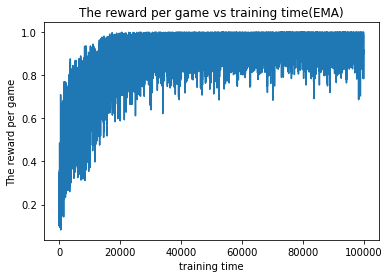

In [10]:
plt.plot(range(n+1), EMA(R_save))    ## plot the reward per game vs training time
plt.title('The reward per game vs training time(EMA)')
plt.xlabel('training time')
plt.ylabel('The reward per game')
plt.show()

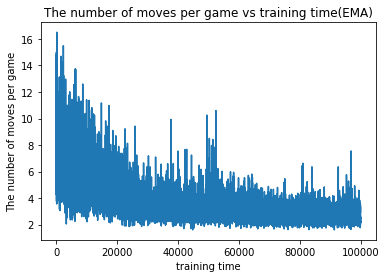

In [11]:
plt.plot(range(n+1), EMA(N_moves_save))  ## plot the number of moves per game vs training time
plt.title('The number of moves per game vs training time(EMA)')
plt.xlabel('training time')
plt.ylabel('The number of moves per game')
plt.show()

## 2 Deep Q-learning

In [1]:
# Training network using Q-learning rule
def DQN_train_model(X,action,reward,next_state,allowed_a_next,done):
    q_values = model_DQN.predict(X)    # Predict Q value based on current state
    if done:
        delta=reward-q_values[action]
    else:
        next_q_values = model_DQN.predict(next_state)  # Predict Q value based on next state
        a_next,_=np.where(allowed_a_next==1)           # Possible actions for next state
        for i in range(len(next_q_values)):
            if i not in a_next:
                next_q_values[i]=-999   # Set Q values of impossible actions to 0
        delta=reward+gamma*np.max(next_q_values)-q_values[action]
    # Update the weights
    model_DQN.update(delta,action,X)

In [2]:
# Choosing action according to epsilon greedy policy
def DQN_get_action(X,a): # X: current state; a: possible actions in the current state
    if np.random.rand() <= epsilon_f:    # choosing action randomly
        a_agent=np.random.permutation(a)[0]
    else:
        q_values = model_DQN.predict(X)  # Predict Q value based on given state
        for i in range(len(q_values)):
            if i not in a:
                q_values[i]=-999         # set Q values of impossible actions to 0
        a_agent=np.argmax(q_values)      # choose the action with max Q value
    return a_agent

In [14]:
# TRAINING LOOP

# INIALIZE THE NUERAL NETWORK WE USE
model_DQN=Neural_network()
model_DQN.parameter_init()
model_DQN.biases_init()

# SAVING VARIABLES
R_DQN = np.zeros([N_episodes, 1])            ## STORE THE REWARD PER GAME
N_moves_DQN = np.zeros([N_episodes, 1])      ## STOR THE NUMBER OF MOVES PER GAME

for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    print(n)                                 ## REMOVE THIS OF COURSE, WE USED THIS TO CHECK THAT IT WAS RUNNING
    
    while Done==0:                           ## START THE EPISODE
        
        a,_=np.where(allowed_a==1)           ## THE POSSIBLE ACTIONS IN THE CURRENT STATE
        a_agent = DQN_get_action(X,a)        ## CHOOSE A ACTION
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)   ## IMPLEMENT THE ACTION
        DQN_train_model(X,a_agent,R,X_next,allowed_a_next,Done)    ## TRAIN MODEL AND UPDATE PARAMETER

        ## THE EPISODE HAS ENDED, UPDATE
        if Done==1:
            R_DQN[n]=np.copy(R)              ## STORE THE REWARD
            N_moves_DQN[n]=np.copy(i)        ## STORE THE NUMBER OF MOVES
            break    
        
        # IF THE EPISODE IS NOT OVER... 
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

print('DQN_Agent, Average reward:',np.mean(R_DQN),'Number of steps: ',np.mean(N_moves_DQN))
        

流式输出内容被截断，只能显示最后 5000 行内容。
95001
95002
95003
95004
95005
95006
95007
95008
95009
95010
95011
95012
95013
95014
95015
95016
95017
95018
95019
95020
95021
95022
95023
95024
95025
95026
95027
95028
95029
95030
95031
95032
95033
95034
95035
95036
95037
95038
95039
95040
95041
95042
95043
95044
95045
95046
95047
95048
95049
95050
95051
95052
95053
95054
95055
95056
95057
95058
95059
95060
95061
95062
95063
95064
95065
95066
95067
95068
95069
95070
95071
95072
95073
95074
95075
95076
95077
95078
95079
95080
95081
95082
95083
95084
95085
95086
95087
95088
95089
95090
95091
95092
95093
95094
95095
95096
95097
95098
95099
95100
95101
95102
95103
95104
95105
95106
95107
95108
95109
95110
95111
95112
95113
95114
95115
95116
95117
95118
95119
95120
95121
95122
95123
95124
95125
95126
95127
95128
95129
95130
95131
95132
95133
95134
95135
95136
95137
95138
95139
95140
95141
95142
95143
95144
95145
95146
95147
95148
95149
95150
95151
95152
95153
95154
95155
95156
95157
95158
95159
95160
95161
95162
9

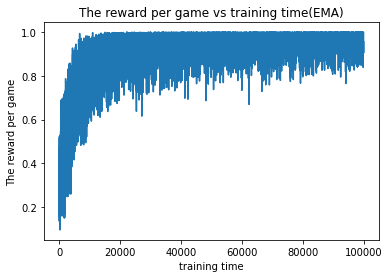

In [15]:
plt.plot(range(n+1), EMA(R_DQN))   ## plot the reward per game vs training time
plt.title('The reward per game vs training time(EMA)')
plt.xlabel('training time')
plt.ylabel('The reward per game')
plt.show()

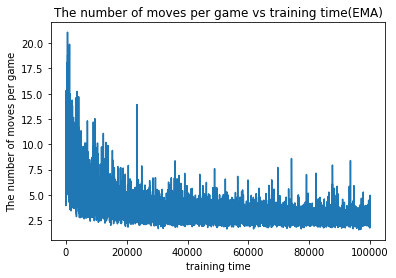

In [16]:
plt.plot(range(n+1), EMA(N_moves_DQN))  ## plot the number of moves per game vs training time
plt.title('The number of moves per game vs training time(EMA)')
plt.xlabel('training time')
plt.ylabel('The number of moves per game')
plt.show()

In [ ]:
f=pd.DataFrame()
f['R_sarsa']=R_save.reshape(N_episodes)
f['N_moves_sarsa']=N_moves_save.reshape(N_episodes)
f['R_DQN']=R_DQN.reshape(N_episodes)
f['N_moves_DQN']=N_moves_DQN.reshape(N_episodes)
f.to_excel(r'result_sarsa_q.xlsx',encoding='utf-8',index=False)

## 3 DQN

In [7]:

action_dim=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
state_dim=np.shape(X)[0]    ## INPUT SIZE

class ReplayBuffer:  ## Define experience replay
    def __init__(self,mem_size,batch_size,start_step,frequency): 
        self.mem_size = mem_size       ## MEMORY SIZE
        self.start_step=start_step     ## START POINT
        self.batch_size = batch_size   ## BATCH SIZE
        self.frequency=frequency       ## LEARNING FREQUENCY
        self.mem_cnt = 0               ## Transition serial number
        self.state_memory = np.zeros((self.mem_size, state_dim))      ## initial state memory
        self.action_memory = np.zeros((self.mem_size, ))              ## initial action memory
        self.reward_memory = np.zeros((self.mem_size, ))              ## initial reward memory
        self.next_state_memory = np.zeros((self.mem_size, state_dim)) ## initial next state memory
        self.a_next_memory = np.zeros((self.mem_size,action_dim))     ## initial possible actions in next state memory
        self.done_memory = np.zeros((self.mem_size, ), dtype=np.bool) ## initial done memory
    
    # Record a transition
    def store_transition(self, state, action, reward, next_state, a_next,done):
        mem_idx = self.mem_cnt % self.mem_size        ## transition index
    
        self.state_memory[mem_idx] = state            ## record state
        self.action_memory[mem_idx] = action          ## record action
        self.reward_memory[mem_idx] = reward          ## record reward
        self.next_state_memory[mem_idx] = next_state  ## record next state
        self.a_next_memory[mem_idx] = a_next          ## record possible actions in next state
        self.done_memory[mem_idx] = done              ## record done
    
        self.mem_cnt += 1
    
    # Randomly sample a batch of transition from memory
    def sample_buffer(self):
        mem_len = min(self.mem_size, self.mem_cnt)

        batch = np.random.choice(mem_len, self.batch_size, replace=True)  
        ## Randomly sample a batch of transition
        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        next_states = self.next_state_memory[batch]
        a_next = self.a_next_memory[batch]
        done = self.done_memory[batch]
    
        return states, actions, rewards, next_states, a_next,done
    
    # Define whether to learn
    def ready(self):
        return (self.mem_cnt > self.start_step) and (self.mem_cnt % self.frequency ==0)

In [8]:
# Training network using Q-learning rule
def DQN_train_model(X,action,reward,next_state,allowed_a_next,done):
    q_values = model_eval.predict(X)      # Use eval network to compute Q values of current action
    if done:
        delta=reward-q_values[action]
    else:
        next_q_values = model_target.predict(next_state) # Use target network to predict max Q values of next state
        a_next=np.where(allowed_a_next==1)[0]            # Possible actions for next state
        for i in range(len(next_q_values)):
            if i not in a_next:
                next_q_values[i]=-999                    # Set Q values of impossible actions to 0
        delta=reward+gamma*np.max(next_q_values)-q_values[action]
    # Update the weights
    model_eval.update(delta,action,X)

In [9]:
# Learning a batch of transition from memory
def learn():
    states, actions, rewards, next_states, allow_a_next,done = memory.sample_buffer()
    a_next=np.where(allowed_a_next==1)

    for i in range(len(states)):
        DQN_train_model(states[i],int(actions[i]),rewards[i],next_states[i],allow_a_next[i],done[i])

In [10]:
# Choosing action according to epsilon greedy policy
def DQN_get_action(X,a):  # X: current state; a: possible actions in the current state
    if np.random.rand() <= epsilon_f:  # choosing action randomly
        a_agent=np.random.permutation(a)[0]
    else:
        q_values = model_eval.predict(X)  # Predict Q value based on given state
        for i in range(len(q_values)):
            if i not in a:
                q_values[i]=-999          # set Q values of impossible actions to 0
        a_agent=np.argmax(q_values)       # choose the action with max Q value
    return a_agent

In [11]:
# Update the target network every c step
def update_target_network():
    # Copy parameters from eval network
    model_target.W1=model_eval.W1
    model_target.W2=model_eval.W2
    model_target.bias_W1=model_eval.bias_W1
    model_target.bias_W2=model_eval.bias_W2
    if model_target.N_h2>0:
        model_target.W3=model_eval.W3
        model_target.bias_W3=model_eval.bias_W3

In [12]:
# TRAINING LOOP

# INIALIZE THE EVAL NUERAL NETWORK
model_eval=Neural_network()
model_eval.parameter_init()
model_eval.biases_init()

# INIALIZE THE TARGET NUERAL NETWORK
model_target=Neural_network()
model_target.parameter_init()
model_target.biases_init()

memory=ReplayBuffer(100000,32,200,5)  # Initialize replay buffer (momery size,batch size,start step,frequency)
c=300                                 # Frequency to update the target network

# SAVING VARIABLES
R_DQN = np.zeros([N_episodes, 1])
N_moves_DQN = np.zeros([N_episodes, 1])

for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    print(n)                                 ## REMOVE THIS OF COURSE, WE USED THIS TO CHECK THAT IT WAS RUNNING
    
    while Done==0:                           ## START THE EPISODE
        
        a,_=np.where(allowed_a==1)           ## THE POSSIBLE ACTIONS IN THE CURRENT STATE
        a_agent = DQN_get_action(X,a)        ## CHOOSE A ACTION
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)  ## IMPLEMENT THE ACTION
        DQN_train_model(X,a_agent,R,X_next,allowed_a_next,Done)   ## TRAIN MODEL AND UPDATE PARAMETER
        
        # Change data shape in order to have the same shape
        if len(X_next)==0:
            X_ = np.zeros(58)
        else:
            X_ = X_next
            
        if len(allowed_a_next)==0:
            a_next = np.zeros(32)
        else:
            a_next=allowed_a_next.reshape(32)
        
        # Store the transition to replay buffer
        memory.store_transition(X,a_agent,R,X_,a_next,Done)
        
        # If True, learn a batch of transition from memory 
        if memory.ready():
            learn()
        
        ## THE EPISODE HAS ENDED, UPDATE
        if Done==1:
            R_DQN[n]=np.copy(R)          ## STORE THE REWARD
            N_moves_DQN[n]=np.copy(i)    ## STORE THE NUMBER OF MOVES
            break    
        
        # IF THE EPISODE IS NOT OVER... 
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        
        # Update the target network every c step
        if i % c == 0:
            update_target_network()
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

print('DQN_Agent, Average reward:',np.mean(R_DQN),'Number of steps: ',np.mean(N_moves_DQN))
        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


流式输出内容被截断，只能显示最后 5000 行内容。
95001
95002
95003
95004
95005
95006
95007
95008
95009
95010
95011
95012
95013
95014
95015
95016
95017
95018
95019
95020
95021
95022
95023
95024
95025
95026
95027
95028
95029
95030
95031
95032
95033
95034
95035
95036
95037
95038
95039
95040
95041
95042
95043
95044
95045
95046
95047
95048
95049
95050
95051
95052
95053
95054
95055
95056
95057
95058
95059
95060
95061
95062
95063
95064
95065
95066
95067
95068
95069
95070
95071
95072
95073
95074
95075
95076
95077
95078
95079
95080
95081
95082
95083
95084
95085
95086
95087
95088
95089
95090
95091
95092
95093
95094
95095
95096
95097
95098
95099
95100
95101
95102
95103
95104
95105
95106
95107
95108
95109
95110
95111
95112
95113
95114
95115
95116
95117
95118
95119
95120
95121
95122
95123
95124
95125
95126
95127
95128
95129
95130
95131
95132
95133
95134
95135
95136
95137
95138
95139
95140
95141
95142
95143
95144
95145
95146
95147
95148
95149
95150
95151
95152
95153
95154
95155
95156
95157
95158
95159
95160
95161
95162
9

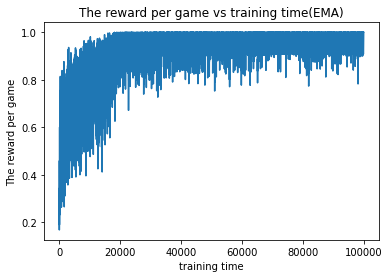

In [14]:
plt.plot(range(n+1), EMA(R_DQN))
plt.title('The reward per game vs training time(EMA)')
plt.xlabel('training time')
plt.ylabel('The reward per game')
plt.show()

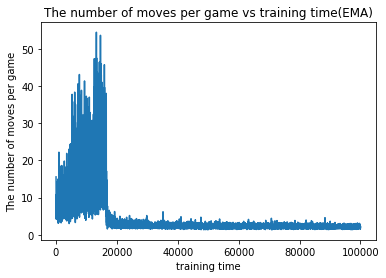

In [15]:
## plot the number of moves per game vs training time

plt.plot(range(n+1), EMA(N_moves_DQN)) 
plt.title('The number of moves per game vs training time(EMA)')
plt.xlabel('training time')
plt.ylabel('The number of moves per game')
plt.show()

In [16]:
g=pd.DataFrame()
g['R_DQN']=R_DQN.reshape(N_episodes)
g['N_moves_DQN']=N_moves_DQN.reshape(N_episodes)
g.to_excel(r'result_DQN.xlsx',encoding='utf-8',index=False)

## Result visualization

In [40]:
re=pd.read_excel(r'result_DQN.xlsx')

In [41]:
re2=pd.read_excel(r'result_sarsa_q.xlsx')

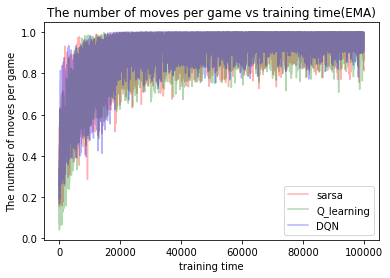

In [134]:
plt.plot(range(N_episodes), EMA(re2['R_sarsa']),c='r',alpha=0.3,label='sarsa')
plt.plot(range(N_episodes), EMA(re2['R_DQN']),c='g',alpha=0.3,label='Q_learning')
plt.plot(range(N_episodes), EMA(re['R_DQN']),c='blue',alpha=0.3,label='DQN')
plt.legend()
plt.title('The number of moves per game vs training time(EMA)')
plt.xlabel('training time')
plt.ylabel('The number of moves per game')
plt.show()

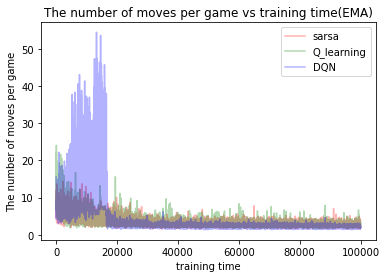

In [124]:
plt.plot(range(N_episodes), EMA(re2['N_moves_sarsa']),c='r',alpha=0.3,label='sarsa')
plt.plot(range(N_episodes), EMA(re2['N_moves_DQN']),c='g',alpha=0.3,label='Q_learning')
plt.plot(range(N_episodes), EMA(re['N_moves_DQN']),c='b',alpha=0.3,label='DQN')
plt.legend()
plt.title('The number of moves per game vs training time(EMA)')
plt.xlabel('training time')
plt.ylabel('The number of moves per game')
plt.show()